# MALIGNANT COMMENTS CLASSIFICATION
##### Problem Statement
The proliferation of social media enables people to express their opinions widely online. However, at the same time, this has resulted in the emergence of conflict and hate, making online environments uninviting for users. Although researchers have found that hate is a problem across multiple platforms, there is a lack of models for online hate detection.

Online hate, described as abusive language, aggression, cyberbullying, hatefulness and many others has been identified as a major threat on online social media platforms. Social media platforms are the most prominent grounds for such toxic behaviour.  

There has been a remarkable increase in the cases of cyberbullying and trolls on various social media platforms. Many celebrities and influences are facing backlashes from people and have to come across hateful and offensive comments. This can take a toll on anyone and affect them mentally leading to depression, mental illness, self-hatred and suicidal thoughts. 

Internet comments are bastions of hatred and vitriol. While online anonymity has provided a new outlet for aggression and hate speech, machine learning can be used to fight it. The problem we sought to solve was the tagging of internet comments that are aggressive towards other users. This means that insults to third parties such as celebrities will be tagged as unoffensive, but “u are an idiot” is clearly offensive.

Our goal is to build a prototype of online hate and abuse comment classifier which can used to classify hate and offensive comments so that it can be controlled and restricted from spreading hatred and cyberbullying. 


## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re


from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from gensim.parsing.preprocessing import STOPWORDS
from nltk.corpus import wordnet
import warnings
warnings.filterwarnings('ignore')

# Importing libraries for classification 
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

# importing metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import f1_score, log_loss, roc_auc_score, roc_curve,auc



### Loading Dataset

In [2]:
#Import Dataset

df_train= pd.read_csv("train.csv")
df_train


,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [3]:
# Creating function to see information of dataset
def features_info(dataset):
    
    print("\nRows in dataset =",dataset.shape[0])
    print("\nColumns in dataset =",dataset.shape[1])
    print("\nFeatures names =\n",dataset.columns)
    print("\nDataset types : \n",dataset.dtypes)
    print("\nNull values in dataset :\n",dataset.isnull().sum())
    print("\nAny duplicated values :",dataset.duplicated().values.any(),"\n")
    for i in dataset.columns:
        print("Total unique values in {} = {}".format(i,dataset[i].nunique()))
    plt.figure(figsize=(10,7))
    sns.heatmap(dataset.isnull())
    plt.title("Graph showing null values",color='steelblue',fontsize=15)
    plt.show()


Rows in dataset = 159571

Columns in dataset = 8

Features names =
 Index(['id', 'comment_text', 'malignant', 'highly_malignant', 'rude', 'threat',
       'abuse', 'loathe'],
      dtype='object')

Dataset types : 
 id                  object
comment_text        object
malignant            int64
highly_malignant     int64
rude                 int64
threat               int64
abuse                int64
loathe               int64
dtype: object

Null values in dataset :
 id                  0
comment_text        0
malignant           0
highly_malignant    0
rude                0
threat              0
abuse               0
loathe              0
dtype: int64

Any duplicated values : False 

Total unique values in id = 159571
Total unique values in comment_text = 159571
Total unique values in malignant = 2
Total unique values in highly_malignant = 2
Total unique values in rude = 2
Total unique values in threat = 2
Total unique values in abuse = 2
Total unique values in loathe = 2


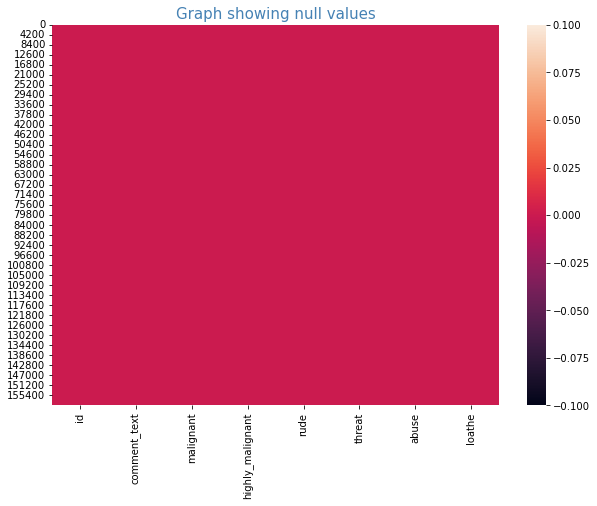

In [4]:
# Let's call the function
features_info(df_train)

    So from above observation we find that there are 159571 rows and 8 columns having object and integer64 data types. 
    There are no null values in dataset and the columns which shows the tells the type of comment are having two unique values either 0 or 1. 0 represent NO while 1 repersents Yes.
    All the comment text present are unique.

In [5]:
# Dropping id feature as there is no use of it
df_train.drop(columns=['id'],inplace=True)

In [6]:
df_train.head(5)

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
# Lets check the length of comment of training data before cleaning
cmnt_len_train = df_train['comment_text'].str.len()

# finding the mean and medians
print(f"Mean of comment length = {cmnt_len_train.mean()}")
print(f"Median of comment length = {cmnt_len_train.median()}")

Mean of comment length = 394.138847284281
Median of comment length = 205.0


     The difference in mean and median is very high this indicates that data is not uniformly distrubuted i.e some comments having high frequency of words while some having a few.

<AxesSubplot:>

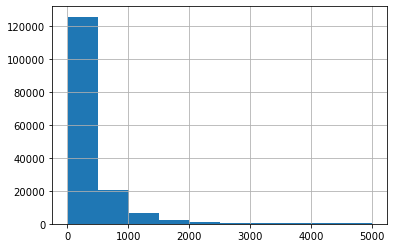

In [8]:
# Distribution plot of comment length before cleaning 
cmnt_len_train.hist()

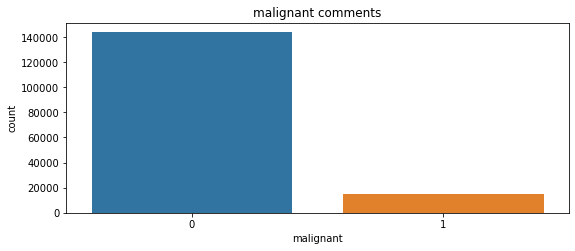

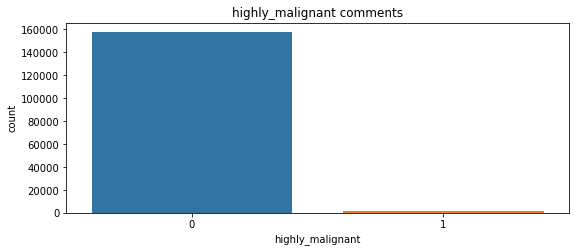

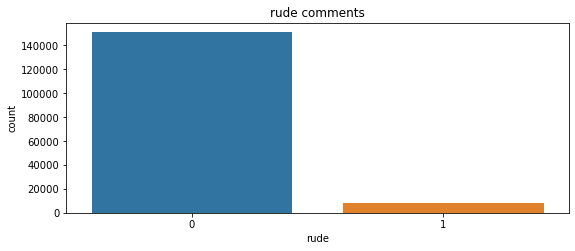

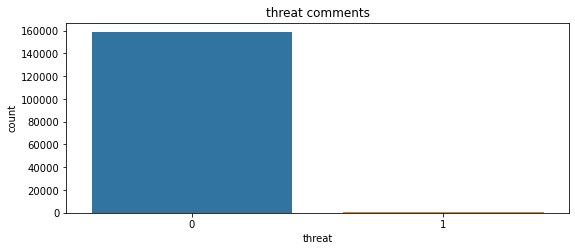

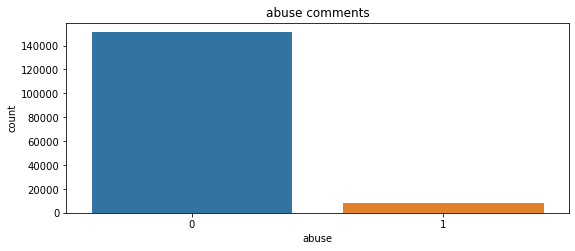

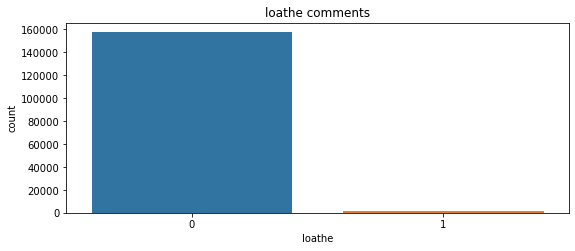

In [9]:
#Let's check the labels present in features
for i in df_train.columns[1:]:
    fig,ax= plt.subplots(figsize=(9,3.5))
    sns.countplot(df_train[i], ax=ax)
    plt.title(f"{i} comments")
    plt.show()

    Based on the above graphs we can say that there is less percentage of negative comments which are in form of malignant, abusive, loathe ,threat and highly_malignant in nature.
    
 -	Malignant: It is the Label column, which includes values 0 and 1, denoting if the comment is malignant or not. 
-	Highly Malignant: It denotes comments that are highly malignant and hurtful. 
-	Rude: It denotes comments that are very rude and offensive.
-	Threat: It contains indication of the comments that are giving any threat to someone. 	
-	Abuse: It is for comments that are abusive in nature. 
-	Loathe: It describes the comments which are hateful and loathing in nature.  
-	ID: It includes unique Ids associated with each comment text given.   
-	Comment text: This column contains the comments extracted from various social media platforms. 


In [10]:
# Calculating percentage of negative comments in each feature
threat_type=[]
threat_pr_age = []
for i in df_train.columns[1:]:
    print('Percentage of negative comments in form of ',i,"=",
         round((df_train[df_train[i]==1].shape[0]/df_train[i].shape[0])*100,2),"%")
    threat_type.append(i)
    threat_pr_age.append(round((df_train[df_train[i]==1].shape[0]/df_train[i].shape[0])*100,2))

Percentage of negative comments in form of  malignant = 9.58 %
Percentage of negative comments in form of  highly_malignant = 1.0 %
Percentage of negative comments in form of  rude = 5.29 %
Percentage of negative comments in form of  threat = 0.3 %
Percentage of negative comments in form of  abuse = 4.94 %
Percentage of negative comments in form of  loathe = 0.88 %


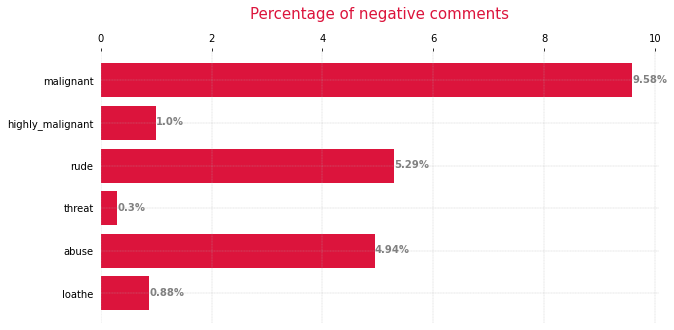

In [11]:
# Let's plot the bargraph showing the percentage of negative comments.
# Figure size
fig,ax = plt.subplots(figsize = (10,5))

# Horizontal bar plot
ax.barh(width=threat_pr_age, y=threat_type, align='center', color='crimson')
ax.invert_yaxis()

# Remove axes splines
for s in ['top','bottom','left','right']:
    ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position("top")
ax.yaxis.set_ticks_position("none")

# Add x, y gridlines
ax.grid(b=True, linestyle='--', lw=0.3)

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width(), i.get_y()+0.45, str(round((i.get_width()), 2))+"%",
            fontweight='bold', color='grey', fontsize=10)

# Setting title
ax.set_title("Percentage of negative comments", fontsize=15, color='crimson', pad=15)
plt.show()

In [12]:
# Let's plot the correlation chart

df_train.corr().style.background_gradient(cmap='rocket')

,malignant,highly_malignant,rude,threat,abuse,loathe
malignant,1.000000,0.308619,0.676515,0.157058,0.647518,0.266009
highly_malignant,0.308619,1.000000,0.403014,0.123601,0.375807,0.201600
rude,0.676515,0.403014,1.000000,0.141179,0.741272,0.286867
threat,0.157058,0.123601,0.141179,1.000000,0.150022,0.115128
abuse,0.647518,0.375807,0.741272,0.150022,1.000000,0.337736
loathe,0.266009,0.201600,0.286867,0.115128,0.337736,1.000000


In [13]:
# Let's create another feature whihc contains overall classification of all positive & negative comments
df_train['negative_cmnts'] = df_train.iloc[:,1:].max(axis=1)

In [14]:
df_train['negative_cmnts']

0         0
1         0
2         0
3         0
4         0
         ..
159566    0
159567    0
159568    0
159569    0
159570    0
Name: negative_cmnts, Length: 159571, dtype: int64

Value counts in Negative comments feature =
0    143346
1     16225
Name: negative_cmnts, dtype: int64


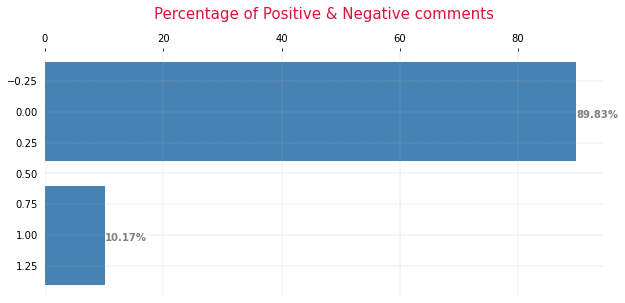

In [15]:
# Find out the value counts of postive comments and negative comments in new feature
print(f"Value counts in Negative comments feature =\n{df_train['negative_cmnts'].value_counts()}")

# Create empty list
labels = []
percentage= []
for i in [0,1]:
    labels.append(int(df_train['negative_cmnts'].value_counts().index[i]))
    percentage.append(round((df_train['negative_cmnts'].value_counts()[i]/df_train.shape[0])*100,2))

# finding percentage of positive and negative comments
fig , ax = plt.subplots(figsize=(10,4.5))
ax.barh(width = percentage, y=labels ,color='steelblue')
ax.invert_yaxis()

# Remove axes splines
for s in ['top','bottom','left','right']:
    ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position("top")
ax.yaxis.set_ticks_position("none")

# Add x, y gridlines
ax.grid(b=True, linestyle='--', lw=0.3)

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width(), i.get_y()+0.45, str(round((i.get_width()), 2))+"%",
            fontweight='bold', color='grey', fontsize=10)

# Setting title
ax.set_title("Percentage of Positive & Negative comments", fontsize=15, color='crimson', pad=15)
plt.show()

In [16]:
df_train.head(5)

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,negative_cmnts
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


### Data Cleaning

In [17]:
# Creating function for cleaning data 

def cleaning_data(text):
    # Replace email addresses with 'email'
    text=re.sub(r'^.+@[^\.].*\.[a-z]{2,}$','email', text)
        
    # Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
    text=re.sub(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$','phonenumber',text)
    
    # converting text into lower case
    text = text.lower()
    
    # Removing all the special characters
    text=re.sub(r'[^\w]+', " ",text)

    # getting only words(i.e removing all the" _ ")
    text=re.sub(r'[\_]+', " ",text)
    
    # getting rid of unwanted characters(i.e remove all the single characters left)
    text=re.sub(r'\s+[a-zA-Z0-9]\s+', " ",text)

    # Remove number
    text=re.sub(r'\d+(\.\d+)?',"",text)
    
    # Removing extra whitespaces
    text = re.sub(r'\s+'," ",text ,flags=re.I)
    
    return text

In [18]:
# text column after removing unwanted characters
df_train['clean_text1'] = df_train['comment_text'].apply(cleaning_data)

In [19]:
# Lets remove stopwords using gensim library
def stop_words(text):
    # splitting the text
    text= text.split()
    
    #stopwords removal
    text = [w for w in text if w not in set(STOPWORDS)]
    
    return text

In [20]:
# text column after removing stopwords
df_train['clean_text2'] =df_train['clean_text1'].apply(stop_words)

In [21]:
df_train.head(5)

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,negative_cmnts,clean_text1,clean_text2
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,explanation why the edits made under my userna...,"[explanation, edits, username, hardcore, metal..."
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,d aww he matches this background colour m seem...,"[d, aww, matches, background, colour, m, seemi..."
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,hey man m really not trying to edit war it jus...,"[hey, man, m, trying, edit, war, guy, constant..."
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,more can make any real suggestions on improve...,"[real, suggestions, improvement, wondered, sec..."
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,you sir are my hero any chance you remember wh...,"[sir, hero, chance, remember, page]"


In [22]:
# creating function to rename pos_tags
def get_wordnet_pos(text_tag):

    if text_tag.startswith('J'):
        return wordnet.ADJ
    elif text_tag.startswith('V'):
        return wordnet.VERB
    elif text_tag.startswith('N'):
        return wordnet.NOUN
    elif text_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [23]:
# Now creating function for the lemmatization

def lemmatization(text):
    
    # getting pos tags
    text_tags = pos_tag(text)
    
    # Now do lemmatization
    text = [(WordNetLemmatizer().lemmatize(w[0], get_wordnet_pos(w[1]))) for w in text_tags]
    
    # joining the tokens
    text = ' '.join(text)
    
    return text

In [24]:
# fully cleaned textual column
df_train['cleaned_comment'] = df_train['clean_text2'].apply(lemmatization)

In [25]:
df_train.head(5)

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,negative_cmnts,clean_text1,clean_text2,cleaned_comment
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,explanation why the edits made under my userna...,"[explanation, edits, username, hardcore, metal...",explanation edits username hardcore metallica ...
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,d aww he matches this background colour m seem...,"[d, aww, matches, background, colour, m, seemi...",d aww match background colour m seemingly stuc...
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,hey man m really not trying to edit war it jus...,"[hey, man, m, trying, edit, war, guy, constant...",hey man m try edit war guy constantly remove r...
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,more can make any real suggestions on improve...,"[real, suggestions, improvement, wondered, sec...",real suggestion improvement wonder section sta...
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,you sir are my hero any chance you remember wh...,"[sir, hero, chance, remember, page]",sir hero chance remember page


In [26]:
# Sample before cleaning
df_train['comment_text'][3]

'"\nMore\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It\'s listed in the relevant form eg Wikipedia:Good_article_nominations#Transport  "'

In [27]:
# sample after cleaning
df_train['cleaned_comment'][3]

'real suggestion improvement wonder section statistic later subsection type accident think reference need tidy exact format date format later preferences format style reference want let know appear backlog article review guess delay reviewer turn list relevant form wikipedia good article nomination transport'

In [28]:
# Lets check the length of comment text after cleaning training dataset
cmnt_len_new = df_train['cleaned_comment'].str.len()

# finding the mean and medians 
print(f"Mean of comment length = {cmnt_len_new.mean()}")
print(f"Median of comment length = {cmnt_len_new.median()}")

Mean of comment length = 212.9157491022805
Median of comment length = 107.0


<AxesSubplot:>

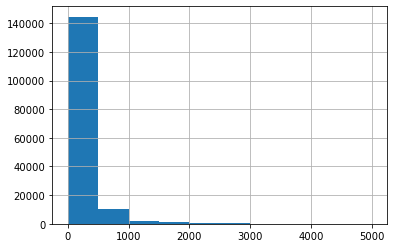

In [29]:
# Distribution plot of comment lengt after cleaning 
cmnt_len_new.hist()

In [30]:
pip install wordcloud

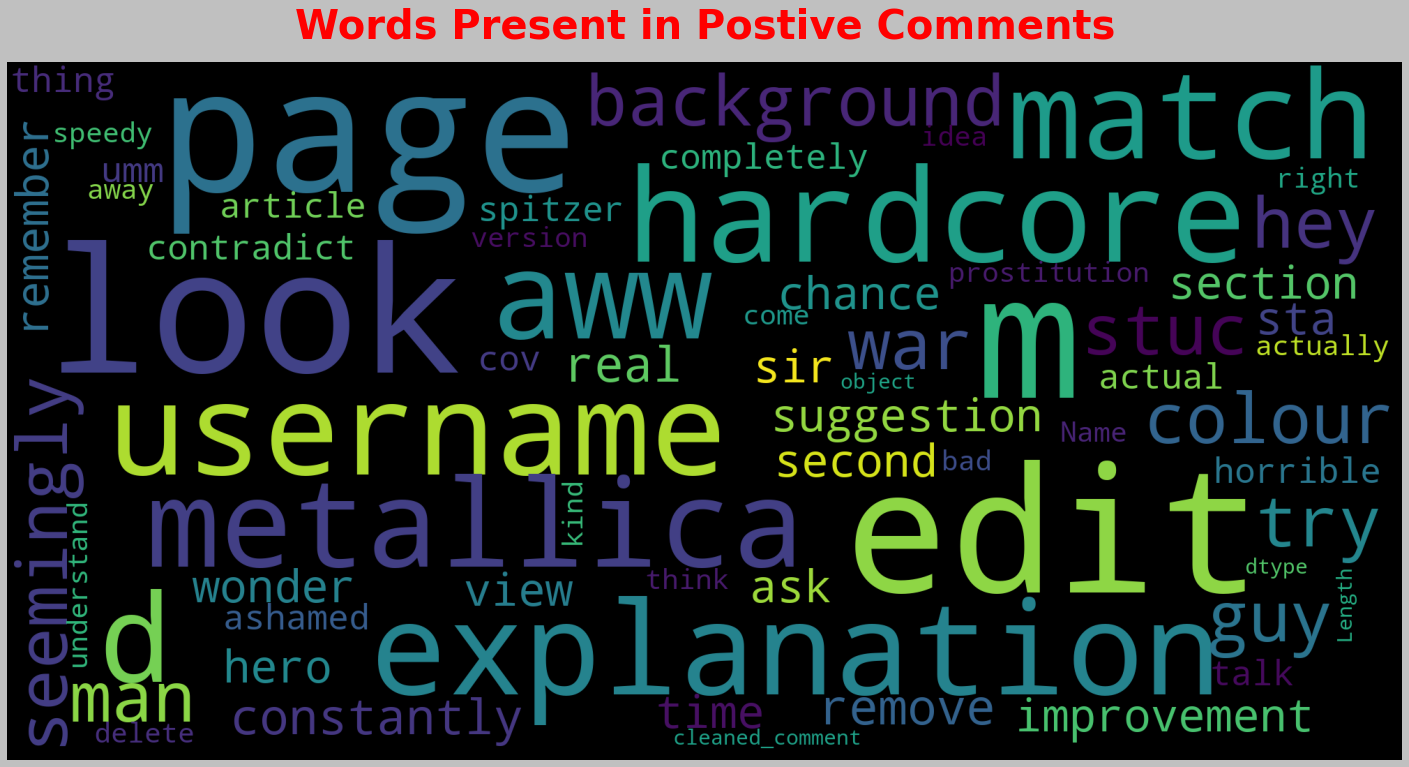

In [31]:
# Using WordCloud let's find the most repeated words
from wordcloud import WordCloud

plt.figure(figsize=(25,15), facecolor='silver')
word_cloud = WordCloud(background_color='black', max_words=100, 
                       max_font_size=50, scale=5).generate(
    str(df_train['cleaned_comment'][df_train['negative_cmnts']==0]))

plt.imshow(word_cloud)
plt.axis('off')
plt.title("Words Present in Postive Comments",fontsize=40, 
          color='red', pad=25, fontweight='bold')
plt.show()

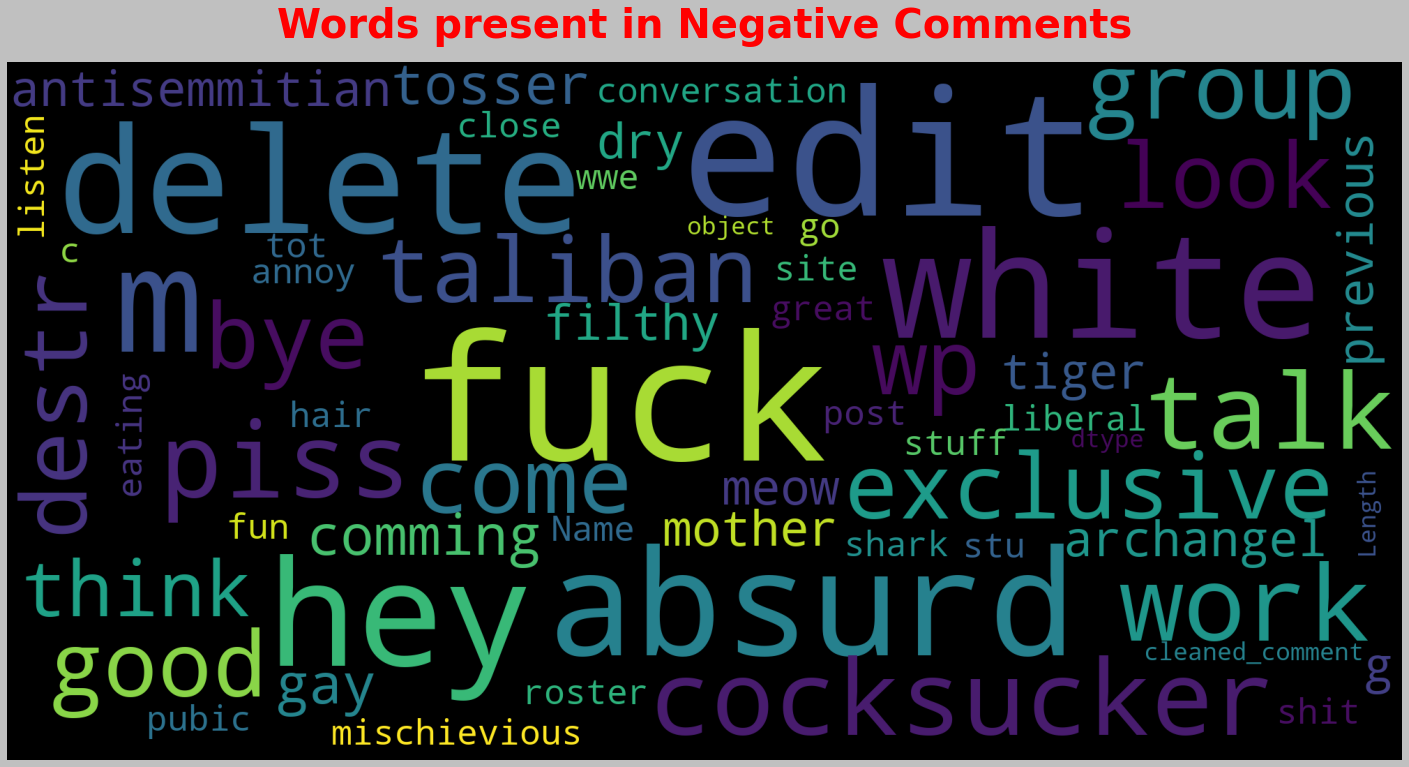

In [32]:
# Using WordCloud for negative words present in comments
plt.figure(figsize=(25,15), facecolor='silver')
word_cloud = WordCloud(background_color='black', max_words=100, max_font_size=50, 
                      scale=5).generate(str(
    df_train['cleaned_comment'][df_train['negative_cmnts']==1]))

plt.imshow(word_cloud)
plt.axis('off')
plt.title("Words present in Negative Comments",fontsize=40, 
          color='red', pad=25, fontweight='bold')

plt.show()

In [33]:
# let's see those comments whose text length is less than 3
df_train[df_train['cleaned_comment'].str.len()<3]

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,negative_cmnts,clean_text1,clean_text2,cleaned_comment
177,"86.29.244.57|86.29.244.57]] 04:21, 14 May 2007",0,0,0,0,0,0,0,may,[],
627,Seems we both have some.,0,0,0,0,0,0,0,seems we both have some,[],
1049,40913.4416666667,0,0,0,0,0,0,0,,[],
2098,"No, it doesn´t.80.228.65.162",0,0,0,0,0,0,0,no it doesn,[],
2407,"Here, here and here.",0,0,0,0,0,0,0,here here and here,[],
...,...,...,...,...,...,...,...,...,...,...,...
155745,"If you have more to say, put",0,0,0,0,0,0,0,if you have more to say put,[],
156766,"""\n\nNeither do I. T/C """,0,0,0,0,0,0,0,neither do t,[t],t
158438,39845.4006944444,0,0,0,0,0,0,0,,[],
158744,hi \n\nwho is this 65.7.162.38,0,0,0,0,0,0,0,hi who is this,[hi],hi


In [34]:
# Dropping comments less than string length of 3
df_train.drop(df_train[df_train['cleaned_comment'].str.len()<3].index, inplace=True)

In [35]:
# New shape of traning dataset
df_train.shape

(159362, 11)

# Feature Extraction for Model Building

In [36]:
# Let's copy the data for model building
df_train1 = df_train[['cleaned_comment','negative_cmnts']].copy()

In [37]:
df_train1.head(5)

,cleaned_comment,negative_cmnts
0,explanation edits username hardcore metallica ...,0
1,d aww match background colour m seemingly stuc...,0
2,hey man m try edit war guy constantly remove r...,0
3,real suggestion improvement wonder section sta...,0
4,sir hero chance remember page,0


In [38]:
# Convert text data into vector form 
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer(min_df=4)
# fitting
fitting_idf = tf_idf.fit(df_train1['cleaned_comment'])


In [39]:
#Due to insufficient memory we can not use dataframe method to see all the features extracted.

def vectorization(fitting_data):
    
    return tf_idf.transform(df_train1['cleaned_comment'])

In [40]:
# independent features
x=vectorization(fitting_idf)
x.shape

(159362, 34312)

In [41]:
# Dependent feature
y = df_train1['negative_cmnts']
y.shape

(159362,)

#### As our target or depedent data is labeled either 0 or 1 which indicates that we are dealing with Classification type of problem. Let's builid a model on Classification now

#### Spliting dataset into training and testing 

In [42]:
# Let's split the train and test dataset
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=45,stratify=y)
print("Train shapes : X = {}, y = {}".format(x_train.shape,y_train.shape))
print("Test shapes : X = {}, y = {}".format(x_test.shape,y_test.shape))
# Success
print("\nTraining and testing split was successful.")

Train shapes : X = (111553, 34312), y = (111553,)
Test shapes : X = (47809, 34312), y = (47809,)

Training and testing split was successful.


In [43]:
# create empty list to store metrices scores
Model = []
Accuracy = []
Log_loss = []
CVScore = []
Std = []
ROC_AUC = []


def classification(model):
    print(30*" ",model,10*" ")
    Model.append(str(model))
    
    # Training score
    model.fit(x_train,y_train)
    print("\nTraining Score {} %".format(round(model.score(x_train,y_train)*100,2)))
    y_pred = model.predict(x_test)
    
    # Accuracy score value
    acc_score = accuracy_score(y_test, y_pred)
    print("\nAccuracy score = {} %".format(round(acc_score*100,2)))
    Accuracy.append(round(acc_score*100,2))
    
    # Log loss
    log_score = log_loss(y_test, y_pred)
    print("Log loss = %.2f"%log_score)
    Log_loss.append(round(log_score,2))
    
    print("\nConfusion matrix :\n",confusion_matrix(y_test, y_pred))
    print("\nClassification report :\n",classification_report(y_test, y_pred))
    
    # cross validation
    cvs=cross_val_score(model,x,y,cv=6,scoring='roc_auc')
    print("\nCross val score = ",round(cvs.mean()*100,3),"%")
    CVScore.append(round(cvs.mean()*100,3))
    # Standard deviation
    print("Standard deviation = %.4f"%cvs.std())
    Std.append(cvs.std())
    
    # ROC AUC Curve
    fpr, tpr, threshold =roc_curve(y_test, y_pred)
    roc_auc = auc(fpr,tpr)
    print("\nROC AUC :",roc_auc*100)
    ROC_AUC.append(roc_auc)
    
    #Plotting ROC AUC Curve
    #plt.figure(13,6)
    #plt.subplot(911)
    #plt.plot(fpr, tpr, color='orange', lw=0.3, label="AUC :%.2f"%roc_auc)
    #plt.plot([0,1],[0,1], lw=3, linestyle='--', color='steelblue')
    #plt.title(str(model))
    #plt.xlabel("False Positive Rate")
    #plt.ylabel("True Positive Rate")
    #plt.show()
    print("\n",30*"*-*")

In [44]:
classification(LogisticRegression())

                               LogisticRegression()           

Training Score 96.04 %

Accuracy score = 95.55 %
Log loss = 1.54

Confusion matrix :
 [[42732   210]
 [ 1917  2950]]

Classification report :
               precision    recall  f1-score   support

           0       0.96      1.00      0.98     42942
           1       0.93      0.61      0.74      4867

    accuracy                           0.96     47809
   macro avg       0.95      0.80      0.86     47809
weighted avg       0.95      0.96      0.95     47809


Cross val score =  97.188 %
Standard deviation = 0.0010

ROC AUC : 80.06162755623463

 *-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-*


In [45]:
classification(DecisionTreeClassifier())

                               DecisionTreeClassifier()           

Training Score 99.94 %

Accuracy score = 94.16 %
Log loss = 2.02

Confusion matrix :
 [[41634  1308]
 [ 1482  3385]]

Classification report :
               precision    recall  f1-score   support

           0       0.97      0.97      0.97     42942
           1       0.72      0.70      0.71      4867

    accuracy                           0.94     47809
   macro avg       0.84      0.83      0.84     47809
weighted avg       0.94      0.94      0.94     47809


Cross val score =  83.725 %
Standard deviation = 0.0028

ROC AUC : 83.25203091919504

 *-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-*


In [46]:
classification(RandomForestClassifier())

                               RandomForestClassifier()           

Training Score 99.94 %

Accuracy score = 95.62 %
Log loss = 1.51

Confusion matrix :
 [[42570   372]
 [ 1720  3147]]

Classification report :
               precision    recall  f1-score   support

           0       0.96      0.99      0.98     42942
           1       0.89      0.65      0.75      4867

    accuracy                           0.96     47809
   macro avg       0.93      0.82      0.86     47809
weighted avg       0.95      0.96      0.95     47809


Cross val score =  96.417 %
Standard deviation = 0.0011

ROC AUC : 81.89683502071692

 *-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-*


In [47]:
classification(AdaBoostClassifier())

                               AdaBoostClassifier()           

Training Score 94.78 %

Accuracy score = 94.62 %
Log loss = 1.86

Confusion matrix :
 [[42507   435]
 [ 2138  2729]]

Classification report :
               precision    recall  f1-score   support

           0       0.95      0.99      0.97     42942
           1       0.86      0.56      0.68      4867

    accuracy                           0.95     47809
   macro avg       0.91      0.78      0.83     47809
weighted avg       0.94      0.95      0.94     47809


Cross val score =  89.769 %
Standard deviation = 0.0031

ROC AUC : 77.52925384028919

 *-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-*


In [48]:
classification(GradientBoostingClassifier())

                               GradientBoostingClassifier()           

Training Score 94.28 %

Accuracy score = 94.09 %
Log loss = 2.04

Confusion matrix :
 [[42819   123]
 [ 2703  2164]]

Classification report :
               precision    recall  f1-score   support

           0       0.94      1.00      0.97     42942
           1       0.95      0.44      0.60      4867

    accuracy                           0.94     47809
   macro avg       0.94      0.72      0.79     47809
weighted avg       0.94      0.94      0.93     47809


Cross val score =  90.034 %
Standard deviation = 0.0023

ROC AUC : 72.08813758538246

 *-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-*


In [49]:
# Table view of result of each metrix from above algorithms
evaluations = pd.DataFrame({"Model":Model,"Accuracy":Accuracy,"Log_loss":Log_loss,"ROC_AUC":ROC_AUC,
                                 "CV Score":CVScore,"Stnd_dev":Std})
evaluations

,Model,Accuracy,Log_loss,ROC_AUC,CV Score,Stnd_dev
0,LogisticRegression(),95.55,1.54,0.800616,97.188,0.000965
1,DecisionTreeClassifier(),94.16,2.02,0.832520,83.725,0.002787
2,RandomForestClassifier(),95.62,1.51,0.818968,96.417,0.001084
3,AdaBoostClassifier(),94.62,1.86,0.775293,89.769,0.003111
4,GradientBoostingClassifier(),94.09,2.04,0.720881,90.034,0.002336


###### In our training dataset we have 9:1 ration of labeled data. Due to this after seeing the result of various algorithims , based on the Loss Loss and Roc Auc value we are considering Logistic Regression and RandomForeset Classifier are giving better result compared to others. So using the Randomized SearchCV we will hyper tunne their parameters and will try to find out the best result out of them.


### Hyper-parameter tunnig using Randomized SearchCV

###### Randomg Forest Classifier

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=42,test_size=.30,stratify=y)
parameters={'bootstrap': [True, False],
 'max_depth': [10, 50, 100, None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 300, 500, 800, 1200]}


rfc= RandomForestClassifier()

# Applying Randomized Search CV for hyperparameter tuning with scoring= "accuracy"
rand = RandomizedSearchCV(estimator = rfc, param_distributions = parameters, 
                          n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1,scoring='accuracy')
rand.fit(x_train,y_train)
rand.best_params_

In [52]:
rfc_hyper=RandomForestClassifier(n_estimators= 500,
                           min_samples_split= 2,
                           min_samples_leaf=1,
                           max_depth= 100,
                           bootstrap= False)

In [54]:
rfc_hyper.fit(x_train,y_train)
rfc_hyper.score(x_train,y_train)
pred=rfc_hyper.predict(x_test)
print('Accuracy Score:',accuracy_score(y_test,pred))
print('Log loss : ', log_loss(y_test,pred))
print('Confusion Matrix:',confusion_matrix(y_test,pred))
print('Classification Report:','\n',classification_report(y_test,pred))

Accuracy Score: 0.9302850927649605
Log loss :  2.407868027228566
Confusion Matrix: [[42916    26]
 [ 3307  1560]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.93      1.00      0.96     42942
           1       0.98      0.32      0.48      4867

    accuracy                           0.93     47809
   macro avg       0.96      0.66      0.72     47809
weighted avg       0.93      0.93      0.91     47809



Text(0.5, 1.0, 'Random Forest Classifier')

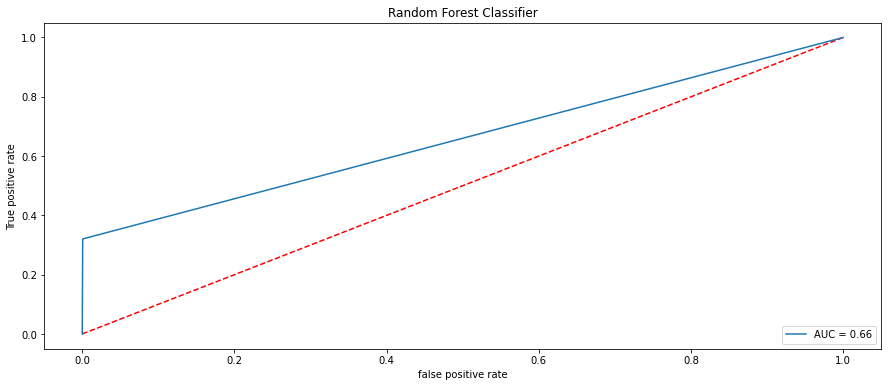

In [55]:
# Roc-Auc score
f,ax = plt.subplots(figsize = (15,6))
# Calculate fpr, tpr and thresholds
fpr, tpr, thresholds = roc_curve(y_test, pred)
ax.plot([0,1],[0,1],'r--')
ax.plot(fpr,tpr,label='AUC = %0.2f'% roc_auc_score(y_test, pred))
ax.legend(loc='lower right')
ax.set_xlabel('false positive rate')
ax.set_ylabel('True positive rate')
ax.set_title('Random Forest Classifier')

##### Logistic Regresison 

In [56]:
# Defining parameters
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

In [57]:

from sklearn.model_selection import RepeatedStratifiedKFold

# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
# Cross validation technique
cv_method = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

lg_hyper = RandomizedSearchCV(estimator=LogisticRegression(), param_distributions=grid, n_jobs=-1, cv=cv_method, scoring='accuracy',error_score=0)
lg_hyper_result = lg_hyper.fit(x, y)

In [58]:
# summarize results
print("Best: %f using %s" % (lg_hyper_result.best_score_, lg_hyper_result.best_params_))
means = lg_hyper_result.cv_results_['mean_test_score']
stds = lg_hyper_result.cv_results_['std_test_score']
params = lg_hyper_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.960392 using {'solver': 'liblinear', 'penalty': 'l2', 'C': 10}
0.960392 (0.001351) with: {'solver': 'liblinear', 'penalty': 'l2', 'C': 10}
0.960386 (0.001338) with: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 10}
0.956886 (0.001121) with: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 1.0}
0.907368 (0.000860) with: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.01}
0.960380 (0.001366) with: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 10}
0.937815 (0.001106) with: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.1}
0.954165 (0.001351) with: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 100}
0.907270 (0.000863) with: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.01}
0.956878 (0.001116) with: {'solver': 'liblinear', 'penalty': 'l2', 'C': 1.0}
0.956271 (0.001430) with: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 100}


In [59]:
# Using the best parameters obtained
lg_final = LogisticRegression(C= 10, penalty= 'l2', solver='lbfgs')
lg_final.fit(x_train,y_train)
y_pred = lg_final.predict(x_test)
print("Accuracy score = ",round(accuracy_score(y_test,y_pred)*100,1),"%")
print('Cross validation score: ',cross_val_score(lg_final,x,y,cv=3,scoring='accuracy').mean()*100)
print("Confusion matrix\n",confusion_matrix(y_test,y_pred))
print("Classification report\n",classification_report(y_test,y_pred))

Accuracy score =  96.0 %
Cross validation score:  95.97080844934301
Confusion matrix
 [[42479   463]
 [ 1451  3416]]
Classification report
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     42942
           1       0.88      0.70      0.78      4867

    accuracy                           0.96     47809
   macro avg       0.92      0.85      0.88     47809
weighted avg       0.96      0.96      0.96     47809



In [60]:
print('Log loss : ', log_loss(y_test,y_pred))

Log loss :  1.3827435887274206


Text(0.5, 1.0, 'Logistic Regression')

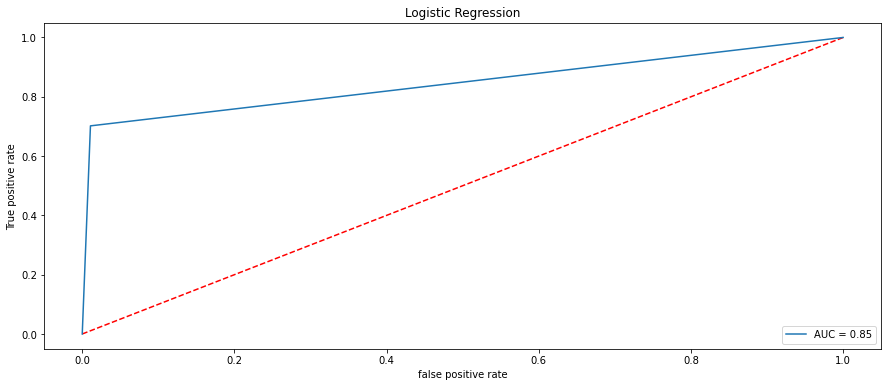

In [61]:
# Roc-Auc score
f,ax = plt.subplots(figsize = (15,6))
# Calculate fpr, tpr and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
ax.plot([0,1],[0,1],'r--')
ax.plot(fpr,tpr,label='AUC = %0.2f'% roc_auc_score(y_test, y_pred))
ax.legend(loc='lower right')
ax.set_xlabel('false positive rate')
ax.set_ylabel('True positive rate')
ax.set_title('Logistic Regression')

        So after tunning the parameters of both the selected algorithms we are finalised Logistic Regression for our model. As  the ROC AUC curve and the score of Logg loss is far better than Random Forest Classifier.
        Logistic Regression gives us Log loss of 1.38 and the Area under the curve is 85% with an Accuracy of 96%.

In [62]:
# Saving the model into pickle file.
import joblib
joblib.dump(lg_final,'malignant_prediction_final.pkl')

['malignant_prediction_final.pkl']

## Loading testing dataset

In [64]:
# loading testing dataset
df_test = pd.read_csv("test.csv")
df_test.head(5)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.



Rows in dataset = 153164

Columns in dataset = 2

Features names =
 Index(['id', 'comment_text'], dtype='object')

Dataset types : 
 id              object
comment_text    object
dtype: object

Null values in dataset :
 id              0
comment_text    0
dtype: int64

Any duplicated values : False 

Total unique values in id = 153164
Total unique values in comment_text = 153164


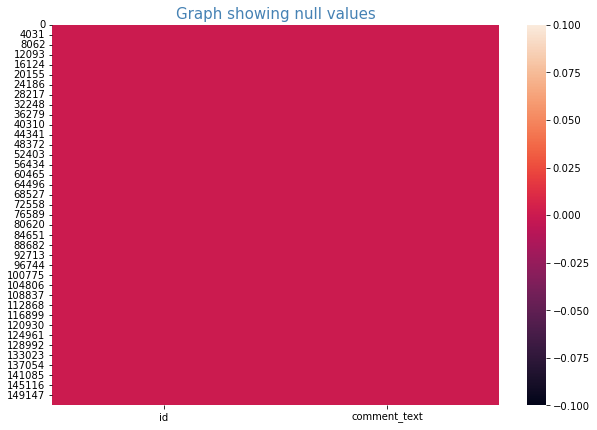

In [65]:
# Checking dataset information
features_info(df_test)

In [66]:
# Dropping id feature as there is no use of it
df_test.drop(columns=['id'],inplace=True)

In [67]:
# Lets check the length of comment text of testing data before cleaning
cmnt_len_test = df_train['comment_text'].str.len()

# finding the mean and medians
print(f"Mean of comment length = {cmnt_len_test.mean()}")
print(f"Median of comment length = {cmnt_len_test.median()}")

Mean of comment length = 394.615234497559
Median of comment length = 206.0


In [68]:
# new column
df_test['clean_text1'] = df_test['comment_text'].apply(cleaning_data)

In [69]:
# apply function to the new column
df_test['clean_text2'] =df_test['clean_text1'].apply(stop_words)

In [70]:
# Apply lemmatization 
df_test['cleaned_comment'] = df_test['clean_text2'].apply(lemmatization)

In [71]:
df_test.head(5)

,comment_text,clean_text1,clean_text2,cleaned_comment
0,Yo bitch Ja Rule is more succesful then you'll...,yo bitch ja rule is more succesful then you ll...,"[yo, bitch, ja, rule, succesful, ll, whats, ha...",yo bitch ja rule succesful ll whats hat sad mo...
1,== From RfC == \n\n The title is fine as it is...,from rfc the title is fine as it is imo,"[rfc, title, fine, imo]",rfc title fine imo
2,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",sources zawe ashton on lapland,"[sources, zawe, ashton, lapland]",source zawe ashton lapland
3,":If you have a look back at the source, the in...",if you have look back at the source the infor...,"[look, source, information, updated, correct, ...",look source information update correct form gu...
4,I don't anonymously edit articles at all.,i don anonymously edit articles at all,"[anonymously, edit, articles]",anonymously edit article


In [72]:
# sample checking
df_test['comment_text'][3]

":If you have a look back at the source, the information I updated was the correct form. I can only guess the source hadn't updated. I shall update the information once again but thank you for your message."

In [73]:
# sample checking
df_test['cleaned_comment'][3]

'look source information update correct form guess source hadn update shall update information thank message'

In [74]:
# Lets check the length of comment text after cleaning testing dataset
cmnt_len_test_new = df_test['cleaned_comment'].str.len()

# finding the mean and medians 
print(f"Mean of comment length = {cmnt_len_test_new.mean()}")
print(f"Median of comment length = {cmnt_len_test_new.median()}")

Mean of comment length = 199.16422266328902
Median of comment length = 93.0


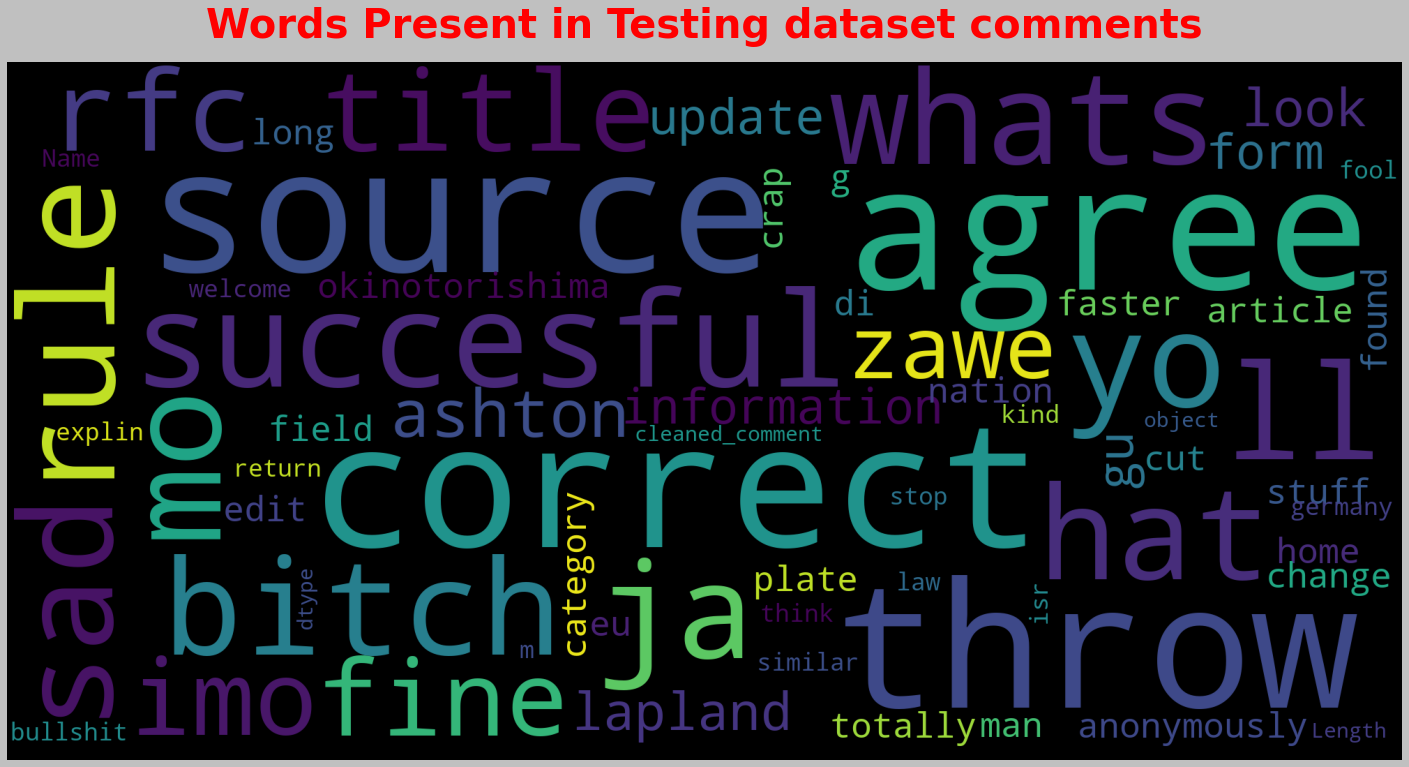

In [75]:
# Using WordCloud for checking the most repeated words in testing dataset comments
from wordcloud import WordCloud
plt.figure(figsize=(25,15), facecolor='silver')
word_cloud = WordCloud(background_color='black', max_words=100, 
                       max_font_size=50, scale=5).generate(
    str(df_test['cleaned_comment']))

plt.imshow(word_cloud)
plt.axis('off')
plt.title("Words Present in Testing dataset comments",fontsize=40, 
          color='red', pad=25, fontweight='bold')
plt.show()

In [76]:
# fitting the vectors form using traning data 
testing= fitting_idf.transform(df_test['cleaned_comment'])
testing

<153164x34312 sparse matrix of type '<class 'numpy.float64'>'
	with 2973935 stored elements in Compressed Sparse Row format>

In [77]:
# Shape of testing data
testing.shape

(153164, 34312)

In [78]:
# Using the selected model, predicting on test data
test_pred = lg_final.predict(testing)

In [79]:
# appending the prediction to the testing dataframe
df_test['Predictions'] = test_pred
df_test.head(5)

,comment_text,clean_text1,clean_text2,cleaned_comment,Predictions
0,Yo bitch Ja Rule is more succesful then you'll...,yo bitch ja rule is more succesful then you ll...,"[yo, bitch, ja, rule, succesful, ll, whats, ha...",yo bitch ja rule succesful ll whats hat sad mo...,1
1,== From RfC == \n\n The title is fine as it is...,from rfc the title is fine as it is imo,"[rfc, title, fine, imo]",rfc title fine imo,0
2,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",sources zawe ashton on lapland,"[sources, zawe, ashton, lapland]",source zawe ashton lapland,0
3,":If you have a look back at the source, the in...",if you have look back at the source the infor...,"[look, source, information, updated, correct, ...",look source information update correct form gu...,0
4,I don't anonymously edit articles at all.,i don anonymously edit articles at all,"[anonymously, edit, articles]",anonymously edit article,0


In [80]:
# Saving into csv file
df_test[['comment_text','Predictions']].to_csv("malignant_prediciton.csv")

In [81]:
# Let's see the value counts
df_test['Predictions'].value_counts()

0    121894
1     31270
Name: Predictions, dtype: int64

Value counts in Negative comments feature =
0    121894
1     31270
Name: Predictions, dtype: int64


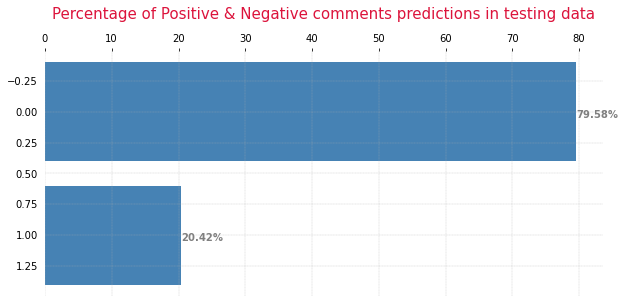

In [82]:
# Find out the value counts of postive comments and negative comments in combined feature
print(f"Value counts in Negative comments feature =\n{df_test['Predictions'].value_counts()}")

# Create empty list
labels = []
percentage= []
for i in [0,1]:
    labels.append(int(df_test['Predictions'].value_counts().index[i]))
    percentage.append(round((df_test['Predictions'].value_counts()[i]/df_test.shape[0])*100,2))

# finding percentage of positive and negative comments
fig , ax = plt.subplots(figsize=(10,4.5))
ax.barh(width = percentage, y=labels ,color='steelblue')
ax.invert_yaxis()

# Remove axes splines
for s in ['top','bottom','left','right']:
    ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position("top")
ax.yaxis.set_ticks_position("none")

# Add x, y gridlines
ax.grid(b=True, linestyle='--', lw=0.3)

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width(), i.get_y()+0.45, str(round((i.get_width()), 2))+"%",
            fontweight='bold', color='grey', fontsize=10)

# Setting title
ax.set_title("Percentage of Positive & Negative comments predictions in testing data", fontsize=15, color='crimson', pad=15)
plt.show()

### Model Predictions

In [83]:
df_test[['comment_text','Predictions']]

,comment_text,Predictions
0,Yo bitch Ja Rule is more succesful then you'll...,1
1,== From RfC == \n\n The title is fine as it is...,0
2,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",0
3,":If you have a look back at the source, the in...",0
4,I don't anonymously edit articles at all.,0
...,...,...
153159,". \n i totally agree, this stuff is nothing bu...",1
153160,== Throw from out field to home plate. == \n\n...,0
153161,""" \n\n == Okinotorishima categories == \n\n I ...",0
153162,""" \n\n == """"One of the founding nations of the...",0


## Conslucion
    The conclusion for our study :-
    
* In training dataset we have only 10% of data which is spreading hate on social media.
* In this 10% data most of the comments are malignant ,rude or abuse.
* After using the wordcloud we find that there are so many abusive words present in the negative comments. While in positive comments there is no use of such comments.
* Some of the comments are very long while some are very short.
    
    From this project we learned a lot.  Gains new techniques and ways to deal with uncleaned data. Find a solution to deal with multiple target features. Tools used for visualizations  gives a better understanding of dataset. We have used a lot of algorithms and find that in the classification problem where we have only two labels , Logistic Regression gives better results compared to others. 
    But due to our system we could not use algorithms which gives much better results in NLP project like GaussinaNB, MultinomailNM. We also used googlecolab and some pipelines techniques but none of them worked here and also it was too much time consuming
